In [1]:
import sys
sys.path.append("/home/twhit/smc_object_detection/")

from utils.misc import select_cuda_device
device = select_cuda_device()

Selected device 1, which has 10820 MB available.


In [2]:
import torch
from torch.distributions import Poisson

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.stats import truncpareto

from hydra import initialize, compose
from hydra.utils import instantiate

from astropy.io import fits
from astropy.wcs import WCS

from bliss.catalog import FullCatalog, convert_mag_to_nmgy, convert_nmgy_to_mag

In [3]:
with initialize(config_path=".", version_base=None):
    cfg = compose(config_name="config")

---

### SDSS image

In [4]:
# Uncomment and run these lines if you haven't previously done so:
# sdss = instantiate(cfg.surveys.sdss)
# sdss.prepare_data()

In [5]:
field52_rband_fits = fits.open('/data/scratch/twhit/m71/6895/3/52/frame-r-006895-3-0052.fits')
field52_rband_wcs = WCS(field52_rband_fits[0].header)

# We will catalog a 320x320 pixel region with lower left corner at (1728, 900)
field52_rband_wcs.pixel_to_world(1728, 900)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (ICRS): (ra, dec) in deg
    (298.40759022, 18.78339333)>

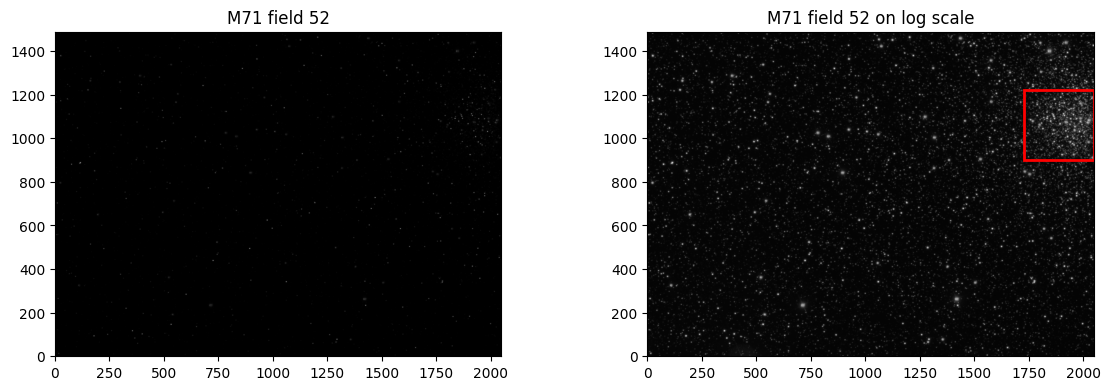

In [6]:
field52_image = field52_rband_fits[0].data
field52_logimage = np.log(field52_image - field52_image.min() + 1)

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
rect = Rectangle((1728, 900), 320, 320, linewidth=2, edgecolor='r', facecolor='none')

_ = ax[0].imshow(field52_image, origin='lower', cmap='gray')
_ = ax[0].set_title('M71 field 52')

_ = ax[1].imshow(field52_logimage, origin='lower', cmap='gray')
_ = plt.gca().add_patch(rect)
_ = ax[1].set_title('M71 field 52 on log scale')

_ = fig.tight_layout()

---

### Hubble catalog

In [7]:
# wget https://archive.stsci.edu/pub/hlsp/acsggct/ngc6838/hlsp_acsggct_hst_acs-wfc_ngc6838_r.rdviq.cal.adj.zpt

hubble_catalog = np.loadtxt('/data/scratch/twhit/m71/hlsp_acsggct_hst_acs-wfc_ngc6838_r.rdviq.cal.adj.zpt',
                            skiprows = 3, usecols=(9, 21, 22))

In [8]:
hubble_r_mag_all = torch.from_numpy(hubble_catalog[:,0])
hubble_r_flux_all = convert_mag_to_nmgy(hubble_r_mag_all)

hubble_ra = torch.from_numpy(hubble_catalog[:,1])
hubble_dec = torch.from_numpy(hubble_catalog[:,2])

hubble_locs_all = FullCatalog.plocs_from_ra_dec(hubble_ra, hubble_dec, field52_rband_wcs)

In [9]:
hubble_locs_mask = (hubble_locs_all[:,0] > 900) & (hubble_locs_all[:,0] < 1220)
hubble_locs_mask &= (hubble_locs_all[:,1] > 1728) & (hubble_locs_all[:,1] < 2048)

hubble_locs = hubble_locs_all[hubble_locs_mask]
hubble_locs -= hubble_locs.min(0).values
hubble_r_mag = hubble_r_mag_all[hubble_locs_mask]
hubble_r_flux = hubble_r_flux_all[hubble_locs_mask]

---

### Store image tiles and tile catalogs

In [10]:
tile_dim = 8
max_objects_per_tile = 25

image = torch.from_numpy(field52_image[900:1220, 1728:2048].astype(np.float32))
tiles = image.unfold(0, tile_dim, tile_dim).unfold(1, tile_dim, tile_dim)

In [11]:
tile_counts = torch.zeros(tiles.shape[0], tiles.shape[1])

locs_index = hubble_locs // tile_dim
tile_locs = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile, 2)
tile_mags = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)
tile_fluxes = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)

for h in range(tiles.shape[0]):
    for w in range(tiles.shape[1]):
        tile_counts[h,w] = (locs_index == torch.tensor([h,w])).all(-1).sum()
        tile_locs[h,w,:tile_counts[h,w].int()] = (hubble_locs % tile_dim)[(locs_index == torch.tensor([h,w])).all(-1)]
        tile_mags[h,w,:tile_counts[h,w].int()] = hubble_r_mag[(locs_index == torch.tensor([h,w])).all(-1)]
        tile_fluxes[h,w,:tile_counts[h,w].int()] = hubble_r_flux[(locs_index == torch.tensor([h,w])).all(-1)]

In [12]:
checkerboard_mask = torch.tensor([[((h + w) % 2 == 0) for w in range(tiles.shape[1])] for h in range(tiles.shape[0])])

In [13]:
torch.save(tiles[checkerboard_mask], 'data/tiles.pt')
torch.save(tile_counts[checkerboard_mask], 'data/counts.pt')
torch.save(tile_locs[checkerboard_mask], 'data/locs.pt')
torch.save(tile_mags[checkerboard_mask], 'data/mags.pt')
torch.save(tile_fluxes[checkerboard_mask], 'data/fluxes.pt')

---

### Flux prior

We fit a flux prior using the tiles that were not stored above (i.e., the opposite-color squares on the checkerboard).

In [14]:
# Filter to sources outside the 320x320 pixel region with r-band mag <= some threshold
r_mag_threshold = 23.0

hubble_r_mag_oob = tile_mags[~checkerboard_mask]
hubble_r_mag_oob_cut = hubble_r_mag_oob[(hubble_r_mag_oob > 0) & (hubble_r_mag_oob <= r_mag_threshold)]

hubble_r_flux_oob = tile_fluxes[~checkerboard_mask]
hubble_r_flux_oob_cut = hubble_r_flux_oob[(hubble_r_mag_oob > 0) & (hubble_r_mag_oob <= r_mag_threshold)]

In [15]:
alpha, trunc, loc, scale = truncpareto.fit(hubble_r_flux_oob_cut)
print(f"alpha = {alpha}, trunc = {trunc}, loc = {loc}, scale = {scale}")

alpha = 0.7417035102844238, trunc = 2375.635986328125, loc = -5.426641632191654, scale = 6.058762073516846


In [16]:
f = np.logspace(np.log10(hubble_r_flux_oob_cut.min().item()), np.log10(trunc), 200)
pf = truncpareto.pdf(f, alpha, trunc, loc, scale)

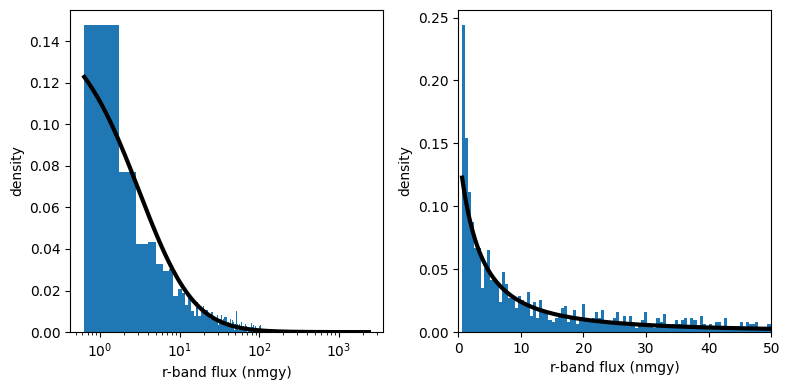

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
_ = ax[0].plot(f, pf, color = 'black', linewidth = 3)
_ = ax[0].hist(hubble_r_flux_oob_cut[hubble_r_flux_oob_cut < trunc], density = True, bins = 2000)
_ = ax[0].set_xscale('log')
_ = ax[0].set_xlabel('r-band flux (nmgy)')
_ = ax[0].set_ylabel('density')

_ = ax[1].plot(f, pf, color = 'black', linewidth = 3)
_ = ax[1].hist(hubble_r_flux_oob_cut[hubble_r_flux_oob_cut < 50], density = True, bins = 100)
_ = ax[1].set_xlim(0, 50)
_ = ax[1].set_xlabel('r-band flux (nmgy)')
_ = ax[1].set_ylabel('density')

_ = fig.tight_layout()

---

### Count prior

We fit a flux prior using the tiles that were not stored above (i.e., the opposite-color squares on the checkerboard).

In [18]:
tile_mags_oob_cut = tile_mags[~checkerboard_mask] * (tile_mags[~checkerboard_mask] <= r_mag_threshold)

hubble_counts_oob_cut = (tile_mags_oob_cut != 0).sum(-1)

In [19]:
# MLE of Poisson rate parameter
rate = (hubble_counts_oob_cut.sum() / ((~checkerboard_mask).sum()))
print(f"rate = {rate.item()}")

rate = 2.0225000381469727


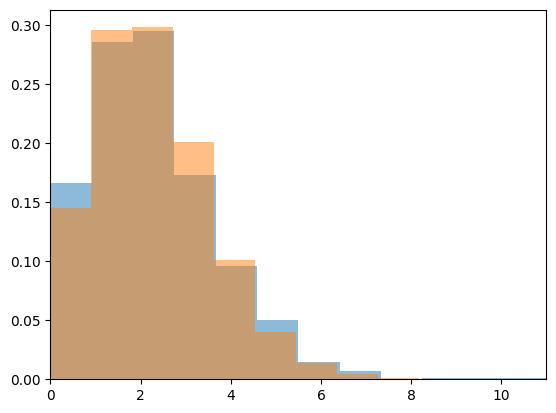

In [20]:
_ = plt.hist(hubble_counts_oob_cut, bins = 12, density = True, alpha = 0.5, label = '')
_ = plt.hist(Poisson(rate).sample([100000]), bins = 11, density = True, alpha = 0.5)
_ = plt.xlim(0, 11)

---